In [2]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.mode.chained_assignment = None

sns.set_style("darkgrid")

# Applied Machine Learning
In this assignment we will explore a dataset about soccer players and referees, focusing predictions and clustering essentially on the players' skin color.

## Preprocessing

Let's have a look at the data:

In [3]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.ix[:5,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0


In [4]:
data.ix[:5,14:]

,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


### NaN values

In [5]:
data.isnull().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

In [6]:
filtered = data.dropna()

In [7]:
len(filtered)/len(data)

0.790649738406333

If we would decide to simply discard all the NaN values, we would keep only 21% of the DataSet. We are mainly interested in the skin color of each player so we will have a closer look at the `rater1` and `rater2` skin rating columns.

### Skin Color

In [8]:
len(data[data.rater1.isnull() & (data.rater2.isnull())])/len(data)

0.14659517352836443

15% of the dataset will be discarded as it doesn't give any information about the skin color.

In [9]:
skin_data = data.dropna(how='all', subset=['rater1','rater2'])

We will also drop the cell with missing IAT or Exp score as there are only 152

In [10]:
skin_data = skin_data.dropna(how='all', subset=['meanIAT', 'nIAT'])

In [11]:
len(skin_data[skin_data.rater1.isnull() | (skin_data.rater2.isnull())])

0

We can observe that there were always values for both `rater1` and `rater2` or not any values. Let's have a look at the data for which the raters gave a different skin color.

In [12]:
skin_data_differ = skin_data[skin_data.rater1 != skin_data.rater2]

In [13]:
len(skin_data_differ)/len(skin_data)

0.23189896198219623

For 23% of the player the two raters gave a different value. Let's see if they gave skin colors that are almost the same or opposite skin colors:

In [14]:
skin_data['skin_difference'] = skin_data.apply(lambda x: abs(x['rater1'] - x['rater2']), axis=1)

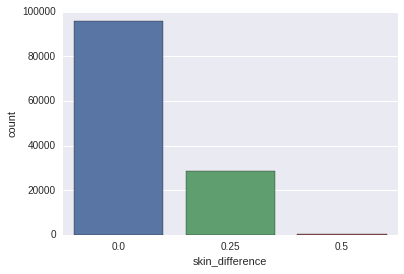

In [15]:
palette = sns.color_palette()
sns.countplot(x="skin_difference", data=skin_data);

If the two raters differ, it is only by one on the 5-point scale or by 2. We decide to keep the average value of the two raters on a 0 to 8 scale. (so that the average keep all the information)

In [16]:
skin_data['skin'] = skin_data.apply(lambda x: (x['rater1']+x['rater2'])/2*4, axis=1)

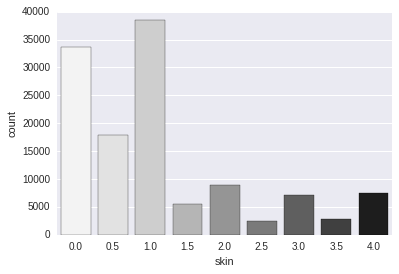

In [17]:
sns.countplot(x="skin", data=skin_data, palette=sns.color_palette("Greys", 9));

Since we are looking at data from countries with predominantly caucasion populations, it seems reasonable to have a larger white population.

### Age
There are not any missing birthday value. We will have a look at the age distribution.

In [18]:
# The birthday string is converted into a datetime type
import datetime
skin_data['birthday'] = skin_data.apply(lambda x: datetime.datetime.strptime(x['birthday'], "%d.%m.%Y"), axis=1)

In [19]:
skin_data['birthday'].head()

0   1983-08-31
1   1982-01-08
5   1979-11-08
6   1985-11-10
7   1986-04-04
Name: birthday, dtype: datetime64[ns]

In [20]:
import datetime as DT
now = pd.Timestamp(DT.datetime.now())
# We will plot the age in year of the players from their birthday
age = skin_data[['birthday']]
skin_data['age'] = age.apply(lambda x: int((now - x['birthday']).days/365.25) , axis=1)

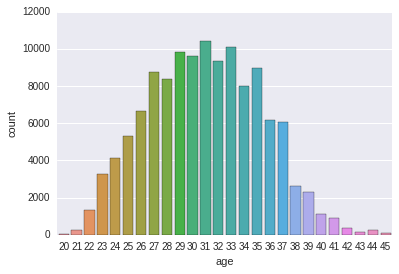

In [21]:
p = sns.countplot(x="age", data=skin_data)

Everything seems fine for the date values. Note that this is the distribution for the data non-aggregated by player. So it is reasonable to assume that older players, who have many more interactions with referees, appear many more times in this countplot than younger players, which is why the mean is surprisingly high.

### League Country

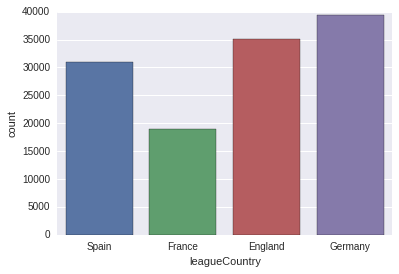

In [22]:
sns.countplot(x="leagueCountry", data=skin_data);

### Height

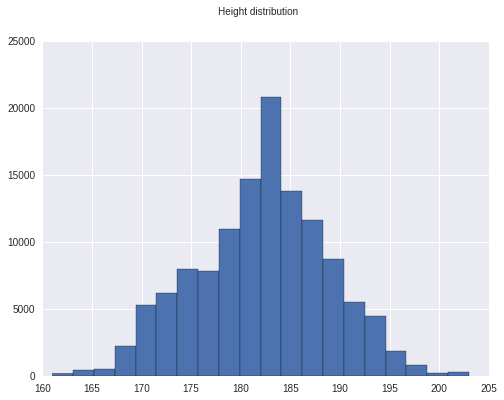

In [23]:
import matplotlib.ticker as ticker
f, ax = plt.subplots(figsize=(8,6))
heights = skin_data['height'].dropna()
plt.hist(heights, bins=20);
f.suptitle("Height distribution");

There is no outliers and the distribution looks normal.

### Weight

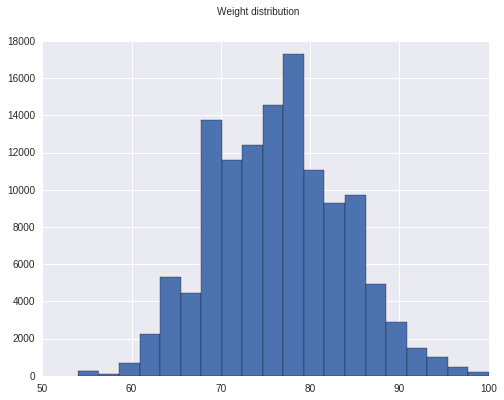

In [24]:
f, ax = plt.subplots(figsize=(8, 6))
plt.hist(skin_data.weight.dropna(), bins=20)
f.suptitle("Weight distribution");

### Position 

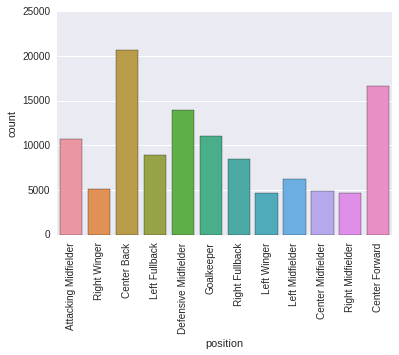

In [25]:
pos = sns.countplot(x="position", data=skin_data);
plt.setp(pos.get_xticklabels(), rotation=90);

In [26]:
missing_values = skin_data['position'].isnull().value_counts()

In [27]:
missing_values[1]/missing_values[0]

0.072870515627424276

7% of the positions are missing. We will replace them by the most by a category `Missing Position`.

### Referees

In [28]:
print('There are ' + str(len(skin_data['refNum'].value_counts())) + ' different referees.')

There are 2967 different referees.


In [29]:
print('Which come from ' + str(len(skin_data['refCountry'].value_counts())) + ' different countries...')

Which come from 155 different countries...


### Standardization, Categorical Features Encoding and Replacing Missing Values

We transform each feature into a representation that is more suitable for the machine learning methods. Each feature will be **standardized** if it is a float number (remove mean value, scale dividing by standard deviation) using the `StandardScaler()` function from `sklearn`. If there are missing values, they will be replaced by the mean, which is 0 after applying the StandardScaler. The categorical features will be **encoded** using the `LabelEncoder()` function which converts categorical variable into numerical values. The learning models consider continuous values and don't handle categorical features, but we hope RandomForest will be robust again those values. The missing categorical variables are replaced by `Missing Category`. We discard the name of the player, as well as the photoID and the birthday as it is a one to one relationship with the skin color.

In [30]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer 
from sklearn.feature_extraction import DictVectorizer

# Replacing missing values for categorical data:
skin_data['position'] = skin_data['position'].fillna('Missing Position')
# For the Alpha_3 there is only one missing value so we will drop it
skin_data = skin_data.dropna(subset=['Alpha_3'])

# Features to be standardized
stand = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'redCards', 
         'yellowReds', 'age', 'skin', 'skin_difference', 'rater1', 'rater2']
# Categorical features to be encoded
cat = ['club', 'leagueCountry', 'position']

standardized = skin_data.copy()
standardized['skin_nonorm'] = standardized['skin']
# Encode categories
for c in cat:
    standardized[c] = LabelEncoder().fit_transform(standardized[c])

# The first function fills the missing values and the second one will apply the standardization 
for s in stand:
    standardized[s] = Imputer(strategy='mean', axis=1).fit_transform(standardized[s])[0]
    standardized[s] = StandardScaler().fit_transform(standardized[s])
    
     
# Discard names of players and photoID
skin_data_dropped = standardized.drop(labels=['playerShort', 'player', 'photoID', 'birthday', 'Alpha_3'], axis=1)

In [31]:
skin_data_dropped.head()

,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_difference,skin,age,skin_nonorm
0,70,3,-0.753585,-0.609844,0,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,1.800031,0.317661,0.458531,1.5
1,51,1,-0.459621,0.785575,12,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,-0.547478,1.617787,0.686558,3.0
5,34,0,-0.018675,-0.749386,1,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.800031,-0.549090,1.370639,0.5
6,48,0,0.716234,0.506492,6,-0.557169,-0.182707,-0.625217,-0.658021,-0.374371,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.800031,-0.549090,0.002477,0.5
7,54,0,-0.312639,-1.168011,4,-0.557169,-0.714417,-0.625217,0.044463,-0.374371,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,-0.547478,2.484538,-0.225550,4.0


# 1. Random Forest Skin Color Regressor

**We use Random Forest Regressor and Classifier because darkness of skin reflect a continuous value, we talked about it with Catasta on slack**

The most important parameters that can affect the accuracy of the random forest regressor are the number of trees in the forest `n_estimators`, the number of features to consider when looking for a best split `max_features`, the maximum depth of the tree `max_depth` and the minimum number of samples required to be at a leaf node `min_samples_leaf`. There are other parameters but we will have a closer look at those ones.

We seperate the data between the features used for prediction and the target features (skin). We need to drop the `rater1`, `rater2`, `skin`, `skin_difference` and `skin_nonorm` values as we want to predict the `skin`.

In [32]:
to_predict = ['rater1', 'rater2', 'skin', 'skin_difference', 'skin_nonorm']
data = skin_data_dropped.drop(labels=to_predict, axis=1)
features = data.columns

# Skin to predict
target = skin_data_dropped.skin_nonorm.apply(lambda x: x/4.0).values.ravel() 


First, all the columns will be used to train the Random Forest Regressor.

### n_estimators
We will test the accuracy of the model for different number of trees. We use 5-folds cross validation to measure the accuracy of the predictive model, we use the mean of the accuracy over the 5 folds to tune the parameters.

In [49]:
from sklearn.metrics import accuracy_score
from sklearn import model_selection

In [33]:
number_trees = [5,10,20,50,100,200]
accuracy = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    scores = model_selection.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

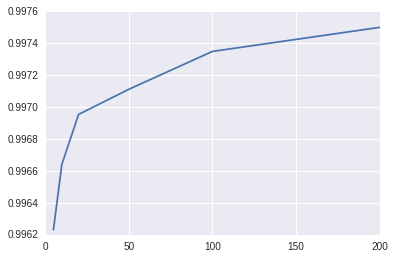

In [34]:
plt.plot(number_trees, accuracy);

Higher number of trees will avoid overfitting (because the model takes the maximum voting of predictions) and give more stable predictions but it takes the model longer to fit the data.

However, notice that this accuracy is impossibly high, which makes sense when we consider that each player appears multiple times in the dataset, due to their presence in multiple dyads. So players will be recognised due to their almost unique personal characteristics (e.g. height, weight, age, position, club). 

### Rethinking the data - aggregation

In order to get more reasonable results and train our model to recognise unseen players, we group on each player and aggregate the information.

We can add some other features on top of the aggregated means of these columns

In [33]:
# Weighted means of the meanIAT and meanExp measures
standardized['weightMeanIAT'] = standardized.meanIAT * standardized.nIAT / standardized.nIAT.sum()
standardized['weightMeanExp'] = standardized.meanExp * standardized.nExp / standardized.nExp.sum()
unique_count = lambda df: len(df.unique())
agg_stderr = lambda df: math.sqrt(np.mean(df**2))

In [34]:
f = {'skin': 'mean', 'skin_difference': 'mean', 'skin_nonorm': 'mean', 'meanIAT': 'mean', 'meanExp': 'mean', 
     'weight': 'mean', 'height': 'mean', 'age': 'mean', 'games': 'mean', 'victories': 'mean', 'ties': 'mean', 
     'defeats': 'mean', 'goals': 'mean', 'yellowCards': 'mean', 'yellowReds': 'mean', 'redCards': 'mean', 
     'refNum': unique_count, 'refCountry': unique_count, 'seIAT': agg_stderr, 'seExp': agg_stderr, 
     'weightMeanIAT': 'mean', 'weightMeanExp': 'mean', 'position': 'mean'}

In [35]:
grouped = standardized.groupby('playerShort').agg(f)

Let's split the data into the feature set and the target data.

We convert here the skin values to integers in $\{0,1\}$, so if we compare it with a classifier, we have a total of 2 classes.

In [36]:
to_predict = ['skin', 'skin_difference', 'skin_nonorm']

# Features
data = grouped.drop(labels=to_predict, axis=1)
target = grouped.skin_nonorm.apply(lambda x: x/4.0).values.ravel() 
features = data.columns

### Feature correlation matrix

Before looking into training and tuning the model, it is interesting to look at the relations between features. To this end, we plotted a feature-correlation matrix.

In [39]:
def correlation_matrix(df, title):
    """Plot the pairwise correlations in df"""
    corr = df.corr(method='pearson')
 
    # Generate a mask for the upper triangle 
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
 
    # Set up the matplotlib figure 
    f, ax = plt.subplots(figsize=(11, 9))
 
    # Generate a custom diverging colormap 
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
    # Draw the heatmap with the mask and correct aspect ratio 
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, square=True,
                linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)
 
    # Rename the labels (movement_activity_i -> mi, stationarity_i -> si) 
    curr_labels = [item.get_text() for item in ax.get_xticklabels()]
    split_labels = [str.split(label, '_') for label in curr_labels]
    labels = [lst[0][0]+lst[-1] for lst in split_labels] # shortening the name 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(reversed(labels))
 
    # Set title 
    f.suptitle(title, fontsize=18)

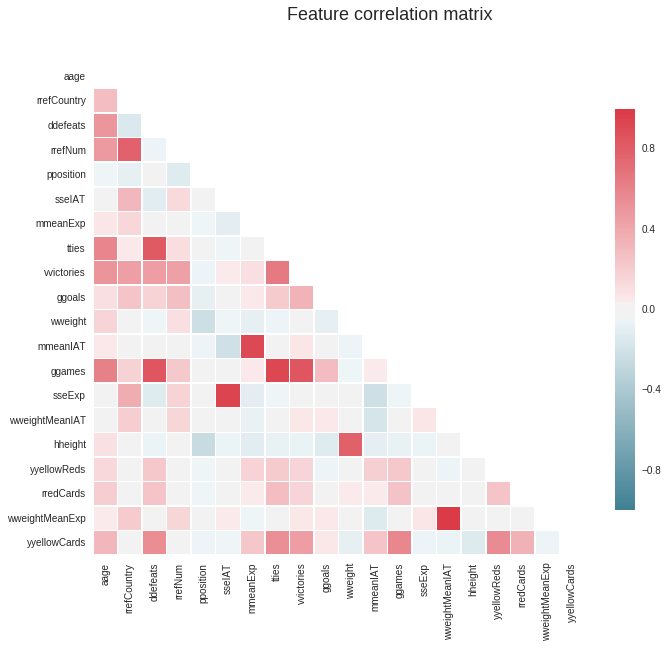

In [137]:
correlation_matrix(data, "Feature correlation matrix")

Some of the features show an obvious correlation with others (e.g. `games` has a strong positive correlation with `ties`, `victories`, `defeats`). Other than these obvious connections, the correlation matrix doesn't show any surprising correlations.

### `n_estimators` with aggregated data

With the grouping on players and aggregation of the features done, let's recompute the score with varying `n_estimators` parameter for our `RandomForestRegressor`.

In [40]:
number_trees = [1,5,10,20,50,100,200]
score = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    scores = model_selection.cross_val_score(tree, data, target, cv=5)
    score.append(scores.mean())

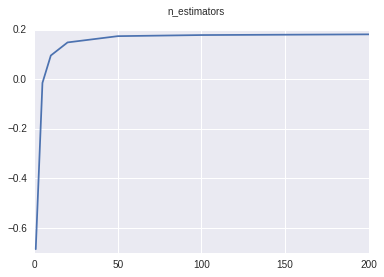

In [41]:
plt.plot(number_trees, score)
plt.suptitle("n_estimators");

The negative score can seem alarming at first, but `RandomForestRegressor`'s `score` function computes the score differently than that of a `RandomForestClassifier`, as is explained in the [doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score). It uses the $R^2$ regression score function (aka coefficient of determination). 

The negative score values indicate that there is a constant model that performs better than ours, with low values of `n_estimators`, which is understandable given the distribution of our data (many more white players than not).

From the progression of the score here, we can see that a good value for `n_estimators` is 100.

### Random Forest accuracy and f1-score
In order to better understand the performance of our Regressor, we can convert the output so that it corresponds to that of a classifier. 

We can then compute the **accuracy** and plot it (i.e. #correctly classified instances/#instances), as it is returned by the RandomForestClassifier. This will give a better idea as to the performance of the regressor, although strictly speaking, we just losing a lot of the information produced by our model (the exact choice why we wanted to use a regressor in the first place). The accuracy metric is computed by rounding the predicted values to the closest integer, so we end up with values in two classes only (white, black). 

A more interesting measure of the performance of a classifier is the **F1-score**. This takes into account the *precision* ($\frac{TP}{TP + FP}$) and *recall* ($\frac{TP}{TP + FN}$) of a model. So our measure will be sensitive to how good our model is at predicting whether the player is dark-skinned or not.

In [44]:
def predict_class_from_reg(model, X, y, test):
    """Returns the predictions of a RandomForestRegressor rounded so as to have classes as output."""
    model.fit(X, y)
    predictions = model.predict(test)
    return np.around(predictions)

In [45]:
def rf_accuracy(model, data, target):
    """Returns the accuracy of a model over a split.
    Rounds the predictions"""
    x_train, x_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.1, random_state=42)
    rounded_pred = predict_class_from_reg(model, x_train, y_train, x_test)
    
    return np.sum(np.equal(rounded_pred, np.around(y_test))) / float(len(y_test))

In [46]:
from sklearn.metrics import f1_score
def rf_f1score(model, data, target):
    """Returns the F1 score of a model over a split of the data."""
    x_train, x_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.1, random_state=42)
    rounded_pred = predict_class_from_reg(model, x_train, y_train, x_test)
    return f1_score(np.around(y_test), rounded_pred)

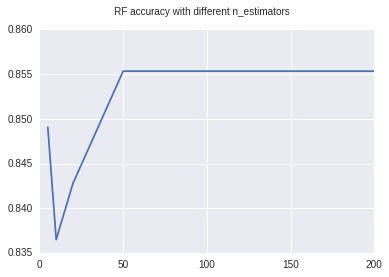

In [45]:
number_trees = [5,10,20,50,100,200]
accuracy = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    accuracy.append(rf_accuracy(tree, data, target))

plt.plot(number_trees, accuracy)
plt.suptitle("RF accuracy with different n_estimators");

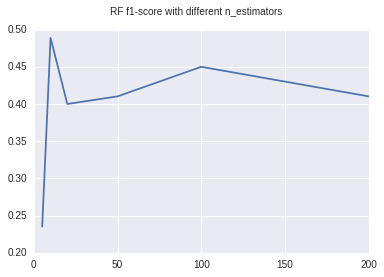

In [54]:
f1 = []

for t in number_trees:
    tree = RandomForestRegressor(n_estimators=t)
    f1.append(rf_f1score(tree, data, target))

plt.plot(number_trees, f1)
plt.suptitle("RF f1-score with different n_estimators");

*Note* that this is the result of only one train-test split, so not a viable judge for determining stable and efficient parameters. This is noticeable by running the cell above several times, and we see the shape of the curve change quite a lot. The result of the actual score plotted previously is far more reliable.

### max_features
As default, the number of features to consider when looking for the best split is equal to the square root of the number of features. We will test it with different values between 1 and the number of features.

In [57]:
max_features = range(1,len(features)+1)
score = []

for m in max_features:
    tree = RandomForestRegressor(n_estimators=100, max_features=m)
    scores = model_selection.cross_val_score(tree, data, target, cv=10)
    score.append(scores.mean())

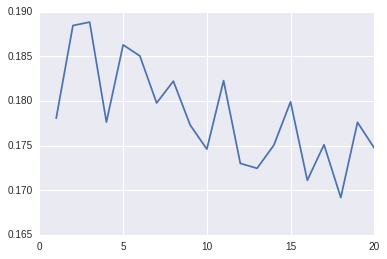

In [58]:
plt.plot(max_features, score);

An efficient and stable choice for max_features seems to be 5.


### max_depth
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure. We compute the score for several depths, including the default value (indicated by `None`).

In [59]:
# None included to compute 
max_depths = [1,5,10,20,50,75]
accuracy = []

for d in max_depths:
    tree = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=d)
    scores = model_selection.cross_val_score(tree, data, target, cv=10)
    accuracy.append(scores.mean())

In [60]:
tree = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=None)
scores = model_selection.cross_val_score(tree, data, target, cv=10)
accuracy.append(scores.mean())

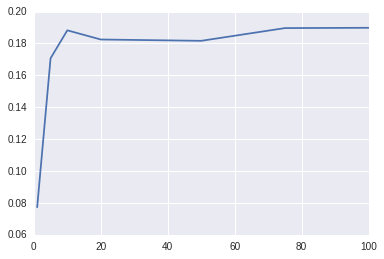

In [61]:
max_depths.append(100) # 100 represents the default value
plt.plot(max_depths, accuracy);

In our case, there is no overfitting problem with a tree having pure nodes. We will keep the default value.

### min_samples_leaf
The minimum number of samples required to be at a leaf node.

In [66]:
min_samples = [1,2,3,4,5,10,20]
accuracy = []

for s in min_samples:
    tree = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=s)
    scores = model_selection.cross_val_score(tree, data, target, cv=5)
    accuracy.append(scores.mean())

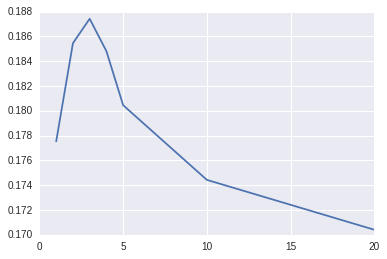

In [67]:
plt.plot(min_samples, accuracy);

If less than 3 samples are in a leaf the model is overfitting and if more than 3 are in a leaf node it is underfitting.

### Feature importance of the trained model

Now we will have a look at the features sorted by their score in the tree with the tuned parameter we found.

In [50]:
def features_importance_rf(X, y, rf, print_=True, plot=True):
    """Print and plot the top features importances in X using the rf classifier.
    Returns columns names in order of increasing importance"""
    rf.fit(X, y)
 
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
 
    cols = X.columns
    ord_cols = []
    # Print the feature ranking 
    if print_:
        print("Feature ranking:")
 
        for f in range(X.shape[1]):
            print("%d. feature n° %d %s (%f)" % (f + 1, indices[f], cols[indices[f]], importances[indices[f]]))
            ord_cols.append(cols[indices[f]])
    else:
        for f in range(X.shape[1]):
            ord_cols.append(cols[indices[f]])  
 
    # Plot the feature importance 
    if plot:
        plt.subplots(figsize=(8,6))
        plt.suptitle("Feature importance", fontsize=18)
        plt.bar(range(X.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
        
    # Compute accuracy
    print("Accuracy:", rf_accuracy(rf, X, y))
    print("F1-score:", rf_f1score(rf, X, y))
 
    return ord_cols

The red bars in the plot represent the feature importance of the trees and the blue lines are the inter-tree variability.

Feature ranking:
1. feature n° 17 seExp (0.104936)
2. feature n° 7 meanIAT (0.100495)
3. feature n° 11 seIAT (0.091301)
4. feature n° 0 meanExp (0.085518)
5. feature n° 8 refNum (0.055482)
6. feature n° 9 victories (0.054914)
7. feature n° 10 games (0.048459)
8. feature n° 15 goals (0.048344)
9. feature n° 18 yellowCards (0.048188)
10. feature n° 4 ties (0.045120)
11. feature n° 13 defeats (0.040957)
12. feature n° 14 refCountry (0.040457)
13. feature n° 12 redCards (0.034260)
14. feature n° 19 position (0.032728)
15. feature n° 5 weight (0.032355)
16. feature n° 2 age (0.030016)
17. feature n° 16 height (0.029655)
18. feature n° 1 weightMeanIAT (0.027595)
19. feature n° 3 weightMeanExp (0.026763)
20. feature n° 6 yellowReds (0.022456)


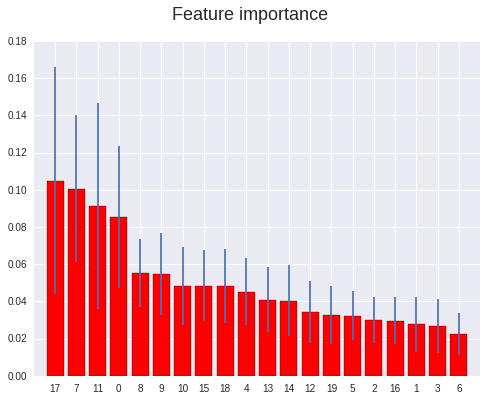

Accuracy: 0.85534591195
F1-score: 0.368421052632


In [51]:
rf = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=3)
sorted_features = features_importance_rf(data, target, rf)

The four highest ranked features are the aggregated standard errors and mean scores of the explicit and implicit racism tests. We can also see that these four features have the highest inter-tree variability. 

Let's see what happens if we remove these top four features.

Feature ranking:
1. feature n° 7 victories (0.090788)
2. feature n° 14 yellowCards (0.083793)
3. feature n° 12 goals (0.080200)
4. feature n° 6 refNum (0.079413)
5. feature n° 11 refCountry (0.079279)
6. feature n° 8 games (0.072913)
7. feature n° 3 ties (0.070201)
8. feature n° 10 defeats (0.067533)
9. feature n° 9 redCards (0.054991)
10. feature n° 4 weight (0.054592)
11. feature n° 13 height (0.053374)
12. feature n° 2 weightMeanExp (0.047946)
13. feature n° 0 weightMeanIAT (0.043911)
14. feature n° 1 age (0.040626)
15. feature n° 5 yellowReds (0.040617)
16. feature n° 15 position (0.039822)


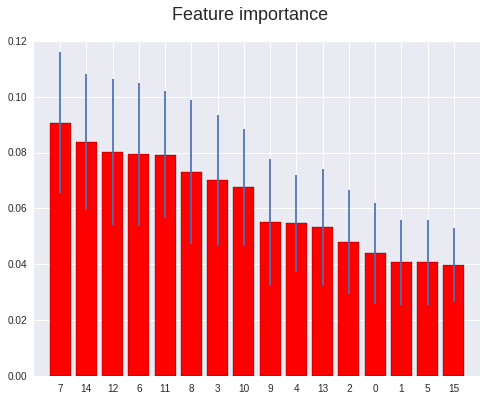

Accuracy: 0.823899371069
F1-score: 0.0


In [52]:
reduced_data = data.drop(sorted_features[:4], axis=1)
rf_red = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=3)
reduced_sorted_features = features_importance_rf(reduced_data, target, rf_red)

Even though the importance measures (red bars) increased slightly, the order of the feature importances measured seem quite stable.

However, by removing the features with highest importance, we get an **accuracy** slightly lower than with those features. 

More interestingly, the **f1-score** varies greatly, where with the four most important features we have a score around 0.36, and **without them**  it is 0. This is because the recall and precision values are extremely low, and our model is very bad at predicting players in the '1' category, when trained without those 4 top features.

### Confusion Matrix

With the help of a confusion matrix, we can look at the way our 'classifier' (rounded regressor predictions) labels the OOB objects it receives.

In [53]:
from sklearn.metrics import confusion_matrix, f1_score
import itertools

In [54]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    np.set_printoptions(precision=2)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

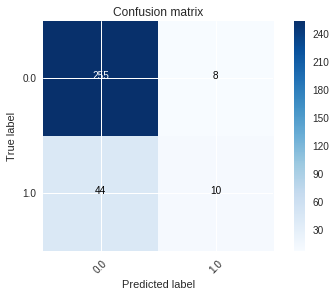

In [73]:
# Our model with best parameters according to our previous tests
rf = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=3)
# Data split 
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.2)
predictions = predict_class_from_reg(rf, x_train, y_train, x_test)
rounded_y = np.around(y_test)
cm = confusion_matrix(rounded_y, predictions)
classes = np.unique(rounded_y)
plot_confusion_matrix(cm, classes)

Our model performs best at predicting players with light skin-tone. For the white player class, we have
- recall $: \frac{255}{255+8} \approx 0.97$ 
- precision $: \frac{255}{255+44} \approx 0.85$ 
For the black player class we have
- recall $: \frac{10}{10+44} \approx 0.19$ 
- precision $: \frac{10}{10+8} \approx 0.55$

# Bonus

As described in the *bonus* part of the assignment, we plot the learning curve of our model, which is essentially the score of the model plotted against the amount of experience, i.e. number of data samples used for its training.

In [55]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve."""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

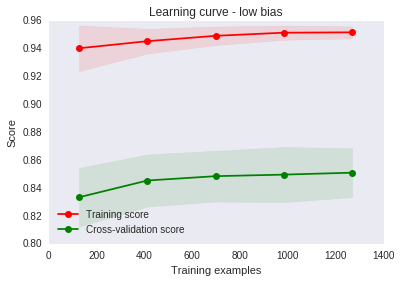

In [56]:
cv = model_selection.ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
title = "Learning curve - low bias"
rounded_target = np.around(target)
rf = RandomForestClassifier(n_estimators=20, max_features=10, min_samples_leaf=3)
plot_learning_curve(rf, title, data, rounded_target, cv=cv, n_jobs=4);

By plotting the learning curve for the Random Forest with the parameters we computed in the previous part, we get two curves that are relatively far appart, and the training score is much higher than the validation score. This is a case of low bias, and the model can be overfitting.

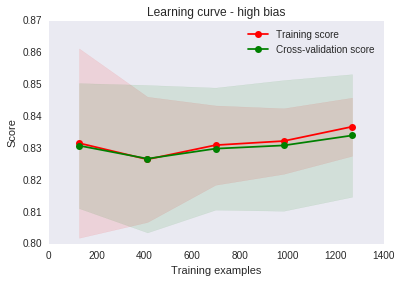

In [57]:
cv = model_selection.ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
title = "Learning curve - high bias"
rounded_target = np.around(target)
rf = RandomForestClassifier(n_estimators=1, min_samples_leaf=40, max_depth=2)
plot_learning_curve(rf, title, data, rounded_target, cv=cv, n_jobs=4);

Above, we plotted the learning curve for a Random Forest with parameters specified to make it much more simple. That means it will have a tendency to underfit. As we can see, even with larger amounts of data available for training, the training score remains quite low, and the validation score looks very similar. So this model has a **high bias**.

# 2. Clustering

We group the referee informations by player and since we did it already in the last part, we can reuse group.

In [58]:
grouped.head()

,skin_nonorm,meanExp,skin_difference,weightMeanIAT,age,weightMeanExp,ties,weight,yellowReds,meanIAT,...,seIAT,redCards,defeats,skin,refCountry,goals,height,seExp,yellowCards,position
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.5,0.494575,1.800031,2.861858e-06,1.370639,3.235924e-06,0.317084,-0.749386,-0.108671,0.346459,...,0.003315,-0.112016,0.306836,-0.549090,37,-0.316979,-0.018675,0.027536,-0.346780,1
aaron-hunt,0.5,0.449220,1.800031,3.807995e-06,-0.225550,5.058827e-06,0.019149,-0.470302,-0.108671,0.348818,...,0.000543,-0.023386,0.207666,-0.549090,25,0.288572,0.128306,0.002506,0.030080,0
aaron-lennon,1.0,0.491482,-0.547478,3.081554e-06,-0.453577,3.467183e-06,0.214040,-1.865721,-0.108671,0.345893,...,0.001268,-0.112016,0.141837,-0.115715,28,-0.049463,-2.517367,0.008914,-0.353528,11
aaron-ramsey,0.0,0.514693,-0.547478,5.548255e-06,-1.365686,6.992590e-06,-0.272310,-0.051676,-0.108671,0.346821,...,0.028116,-0.027647,-0.198705,-0.982466,37,0.022593,-0.606603,0.104541,-0.123403,3
abdelhamid-el-kaoutari,1.0,0.335587,-0.547478,4.243206e-07,-1.137659,4.779943e-07,0.319503,-0.470302,0.864236,0.331600,...,0.006309,0.362271,0.158379,-0.115715,11,-0.345761,-0.312639,0.023426,-0.222989,1


In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

We now compute the silhouette score and remove iteratively features. We keep track of 2 score, the one by silhouette score of the clusterisation by k-mean and its own labels, and the one corresponding to the proportion of correctly partitionned data along the skin value (accuracy = max(partition_accuracy, 1-partition_accuracy) split at skin value = 2.0)

In [60]:
skin_labels = (grouped['skin_nonorm'] < 2.0).astype(int) 
skin_labels.head()

playerShort
aaron-hughes              1
aaron-hunt                1
aaron-lennon              1
aaron-ramsey              1
abdelhamid-el-kaoutari    1
Name: skin_nonorm, dtype: int64

We define the cluster method with the data as parameter

In [61]:
def cluster(X):
    kmeans_model = KMeans(n_clusters=2, random_state=1).fit(X)
    labels = kmeans_model.labels_
    
    silhouette_unsupervised = silhouette_score(X, labels)
    np.mean(silhouette_unsupervised)
    eq = skin_labels == labels
    mean = np.mean(eq)
    skin_partition = max(mean, 1-mean)
    
    return  silhouette_unsupervised, skin_partition

The first iterative ablation of the features is done according to the features importance we found in the previous part. It should logically give good results.

In [62]:
silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

columns = sorted_features
#We always drop skin_nonorm. It was only used for labeling before standardization
for i in range(len(columns)):
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    
    feature_number.append(len(columns))
    print(silhouette_unsupervised, skin_partitionning, columns)
    print("REMOVED FEATURE: ", columns[-1])
    print()
    print()
    columns = columns[:-1]

0.530480813806 0.569085173502 ['seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'refCountry', 'redCards', 'position', 'weight', 'age', 'height', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  yellowReds


0.530499422484 0.569085173502 ['seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'refCountry', 'redCards', 'position', 'weight', 'age', 'height', 'weightMeanIAT', 'weightMeanExp']
REMOVED FEATURE:  weightMeanExp


0.530499422484 0.569085173502 ['seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'refCountry', 'redCards', 'position', 'weight', 'age', 'height', 'weightMeanIAT']
REMOVED FEATURE:  weightMeanIAT


0.530499422484 0.569085173502 ['seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'refCountry', 'redCards

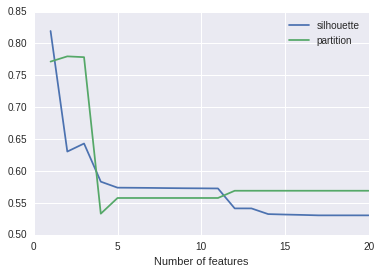

In [63]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

We can see that the silhouette goes up as the number of features go down (easier to cluster). 
We could think that ['seExp', 'seIAT', 'meanIAT', 'meanExp'] give good enough silhouette and partition scores.

In [64]:
print(skin_labels.value_counts())
1200/(1200+385)

1    1200
0     385
Name: skin_nonorm, dtype: int64


0.7570977917981072

But we notice that just outputing everything under 1 category would result in a 75% accuracy, which is only a bit less than the best paritionning accuracy achieved here. Way less spectacular.

Now let's take another approach and instead of removing features iteratively based on the feature importance found in the previous part, we're gonna remove the feature such that it maximizes the silhouette score at the next iteration

In [66]:

silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

columns = sorted_features

#We always drop skin_nonorm. It was only used for labeling before standardization
for i in range(len(columns)):
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    

    feature_number.append(len(columns))
    print(silhouette_unsupervised, skin_partitionning, columns)
    
    if len(columns) == 1:
        break;
    
    max_silhouette = 0
    j = -1
    
    for i in range(len(columns)):
        hole_columns = columns[:i] + columns[i+1:]
        silhouette, _ = cluster(grouped[hole_columns]) 
        if silhouette > max_silhouette:
            j = i
            max_silhouette = silhouette
            

    print("REMOVED FEATURE: ", j, columns[j])
    print()
    print()
    columns = columns[:j] + columns[j+1:]

0.530480813806 0.569085173502 ['seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'refCountry', 'redCards', 'position', 'weight', 'age', 'height', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  11 refCountry


0.554782338277 0.557728706625 ['seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'redCards', 'position', 'weight', 'age', 'height', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  12 position


0.568201208404 0.557728706625 ['seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'redCards', 'weight', 'age', 'height', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  14 height


0.569602594661 0.557728706625 ['seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'redCards', 'weight',

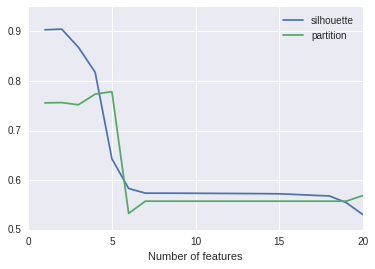

In [67]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

Silhouette reaches a higher score but accuracy stays the same. We can conclude that clusterisation doesn't reveal any significative correlation with Skin color. 


Let's now try by adding the skin feature for sanity check if there is now a clear partition.

In [68]:
silhouettes_unsupervised = []
skin_partitions = []
feature_number = []

columns = ['skin', 'skin_difference'] + sorted_features
#We always drop skin_nonorm. It was only used for labeling before standardization
for i in range(len(columns)):
    silhouette_unsupervised, skin_partitionning = cluster(grouped[columns])
    
    silhouettes_unsupervised.append(silhouette_unsupervised)
    skin_partitions.append(skin_partitionning )
    
    feature_number.append(len(columns))
    print(silhouette_unsupervised, skin_partitionning, columns)
    print("REMOVED FEATURE: ", columns[-1])
    print()
    print()
    columns = columns[:-1]

0.529074517977 0.569085173502 ['skin', 'skin_difference', 'seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'refCountry', 'redCards', 'position', 'weight', 'age', 'height', 'weightMeanIAT', 'weightMeanExp', 'yellowReds']
REMOVED FEATURE:  yellowReds


0.529092669023 0.569085173502 ['skin', 'skin_difference', 'seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'refCountry', 'redCards', 'position', 'weight', 'age', 'height', 'weightMeanIAT', 'weightMeanExp']
REMOVED FEATURE:  weightMeanExp


0.529092669023 0.569085173502 ['skin', 'skin_difference', 'seExp', 'meanIAT', 'seIAT', 'meanExp', 'refNum', 'victories', 'games', 'goals', 'yellowCards', 'ties', 'defeats', 'refCountry', 'redCards', 'position', 'weight', 'age', 'height', 'weightMeanIAT']
REMOVED FEATURE:  weightMeanIAT


0.529092669023 0.569085173502 ['skin', 'skin_difference', 'seExp', 'meanIAT', 'seIAT', '

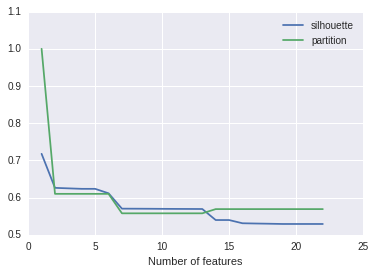

In [69]:
plt.plot(feature_number, silhouettes_unsupervised, label='silhouette');
plt.plot(feature_number, skin_partitions, label='partition');
plt.xlabel('Number of features');
plt.legend();

Surprisingly, the paritition doesn't improve significatively until we only keep the skin related features. Then it achieves not so surprisingly a perfect partition.

Let's now try to have some visualisation of the effect of clusterisation based on the two relevant features:
['seExp', 'seIAT']

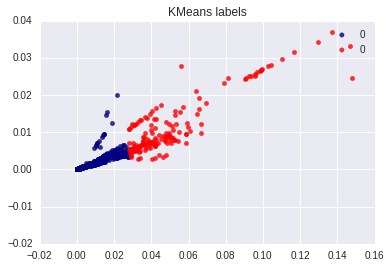

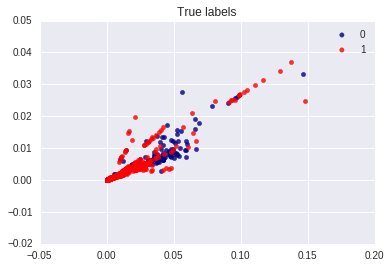

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


X = grouped[['seExp', 'seIAT']]
kmeans_model = KMeans(n_clusters=2, random_state=1).fit(X)
labels = kmeans_model.labels_

skin_labels_nd = skin_labels.as_matrix()

Xnd = X.as_matrix()

x1 = Xnd[labels == 0, 0]
y1 = Xnd[labels == 0, 1]
x2 = Xnd[labels == 1, 0]
y2 = Xnd[labels == 1, 1]

plt.figure()
plt.scatter(x1, y1, color='navy', alpha=.8, label='0')
plt.scatter(x2, y2, color='red', alpha=.8, label='0')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('KMeans labels')


x1 = Xnd[skin_labels_nd == 0, 0]
y1 = Xnd[skin_labels_nd == 0, 1]
x2 = Xnd[skin_labels_nd == 1, 0]
y2 = Xnd[skin_labels_nd == 1, 1]

plt.figure()
plt.scatter(x1, y1, color='navy', alpha=.8, label='0')
plt.scatter(x2, y2, color='red', alpha=.8, label='1')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('True labels')
plt.show()


We can notice that there seems to be a pattern